# 나를 찾아줘 - Class Activation Map 만들기 [프로젝트]

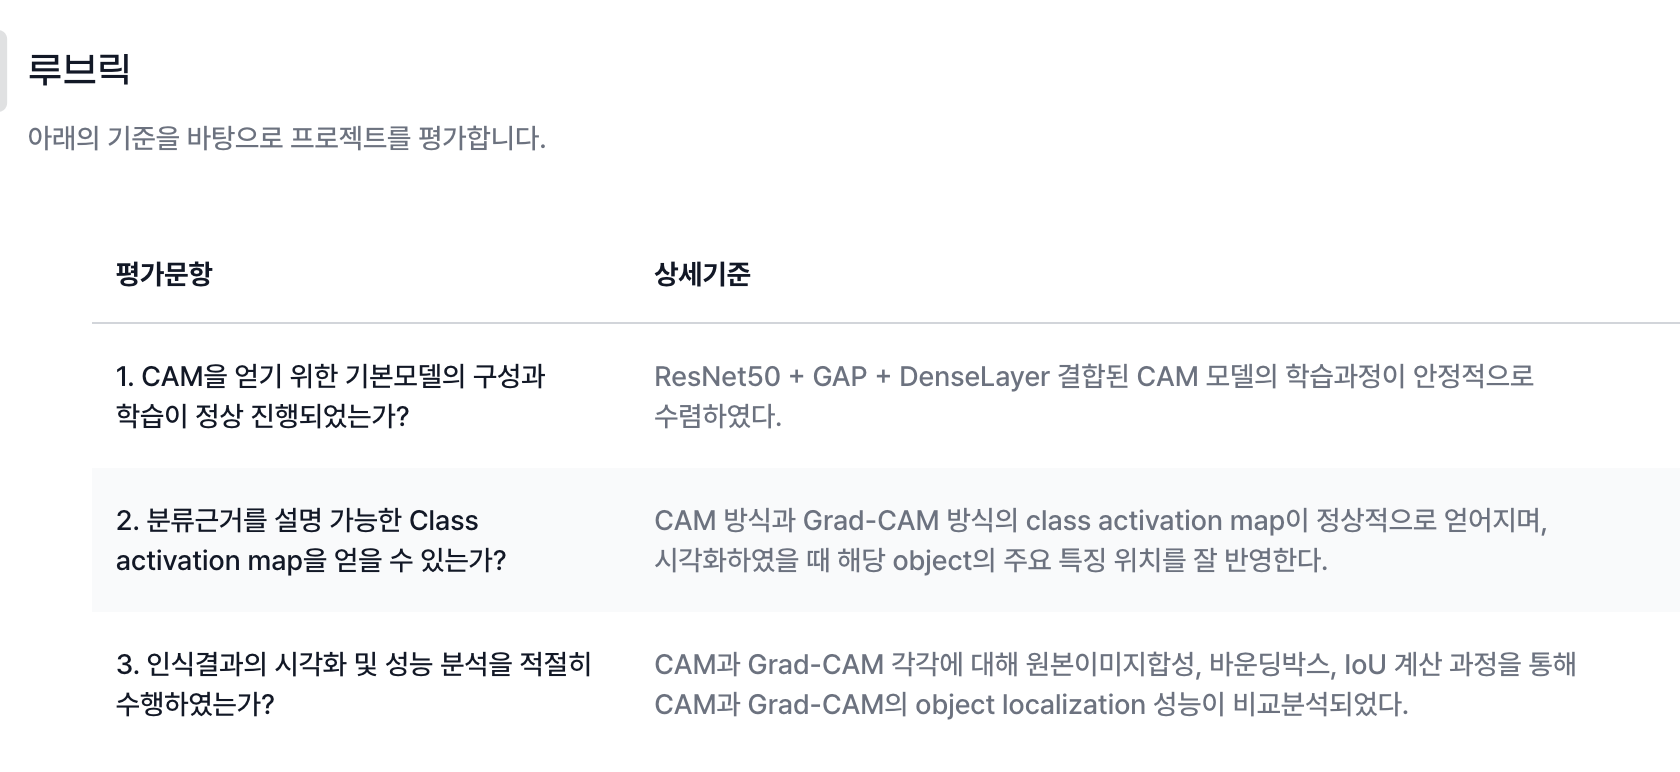

In [1]:
# import library

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image
import os

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# dataset 준비

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

## 모델링 - resnet50(imagenet)

In [4]:
# 간단한 전처리

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [5]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [ ]:
# imagenet으로 학습된 resnet50

num_classes = ds_info.features["label"].num_classes

base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [ ]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=3,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

In [ ]:
cam_model_path = '/aiffel/aiffel/workspace/CAM/mycam_model.h5'
cam_model.save(cam_model_path)

## CAM

label= 11


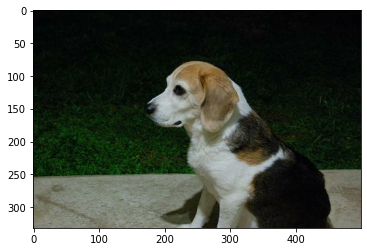

In [7]:
# 개별 이미지 단위 CAM를 위한 데이터 생성 + 테스트 데이터로 확인

def get_one(ds):
    #개별 이미지 단위
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]


item = get_one(ds_test)
print('label=', item['label'])
plt.imshow(item['image'])
plt.show()

In [8]:
#앞서 학습한 모델 파일 로드

cam_model_path = os.getenv('HOME')+'/aiffel/workspace/CAM/mycam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [ ]:
cam_model.summary()

In [9]:
#model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수

def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

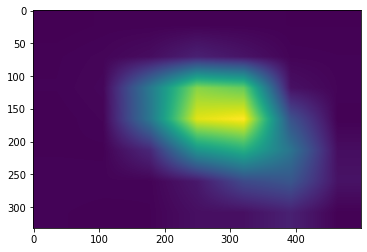

In [10]:
#CAM 확인

cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [11]:
#그려진 CAM이미지 + 원본이미지 하는 함수

def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

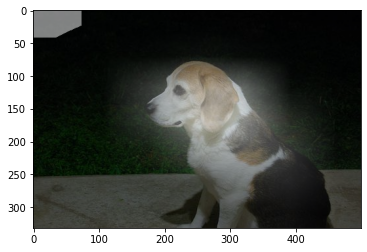

In [12]:
#겹쳐서 활성화 확인하기

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

-> 엉망진창이다. activation dense layer에서 학습이 잘 안됐나..? (해결!)  
원인은 학습이 잘 진행되지 않았기 떄문이였다.

## grad-CAM

label : 116


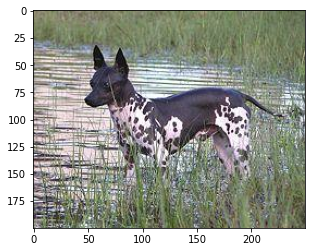

In [13]:
#새로운 test이미지 

item = get_one(ds_test)
print('label :',item['label'])
plt.imshow(item['image'])
plt.show()

In [14]:
# 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용하는 함수

def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

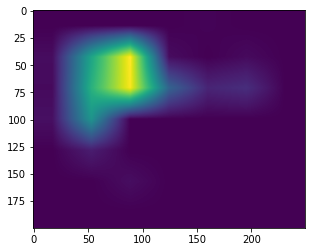

In [18]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

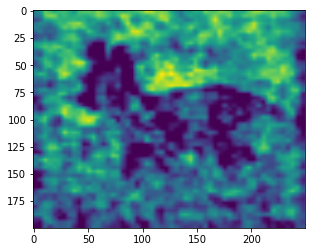

In [16]:
grad_cam_image = generate_grad_cam(cam_model, 'conv2_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

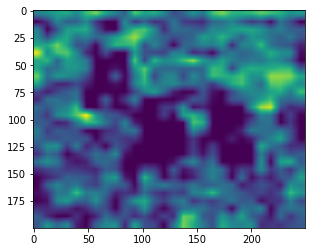

In [17]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

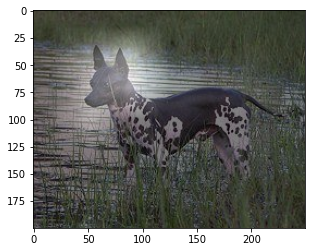

In [19]:
# conv5_bloock3 out 기준

origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## CAM vs grad-CAM 시각화 비교

In [67]:
items = []
for i in range(5):
    item_i = get_one(ds_test)
    while item_i['label'] in [item['label'] for item in items]:
        item_i = get_one(ds_test)
        items.append(item_i)
        print('label:',item_i['label'])
        plt.imshow(item_i['image'])
        
    plt.show()

cam 과 grad-cam의 차이를 직관적으로 파악하기 위해 시각화를 하려했으나,  
시간이 부족해서 하지못하였다. 피드백 이후 추가할 예정

## 바운딩 박스

label : 71


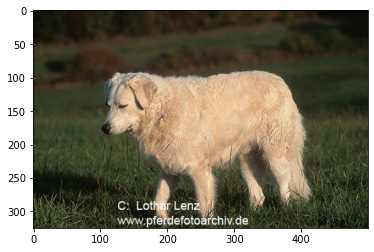

In [20]:
#새로운 test이미지 

item = get_one(ds_test)
print('label :',item['label'])
plt.imshow(item['image'])
plt.show()

In [27]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    #score thresh 이하인 값은 0 처리(cam_image의 히스토그램 파악하여 thresh를 정해보자)
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    #cv2 외곽선 검출
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [28]:
#CAM

cam_image = generate_cam(cam_model, item)
cam_rect = get_bbox(cam_image)
cam_rect

array([[ 34, 289],
       [ 38,  69],
       [462,  76],
       [458, 296]])

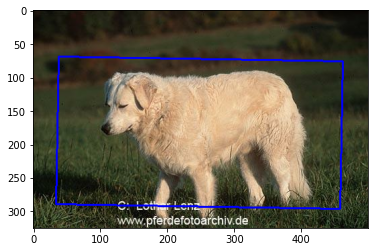

In [29]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [cam_rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [30]:
#grad CAM

grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
gradcam_rect = get_bbox(grad_cam_image)
gradcam_rect

array([[  0, 323],
       [  0,  69],
       [498,  70],
       [498, 323]])

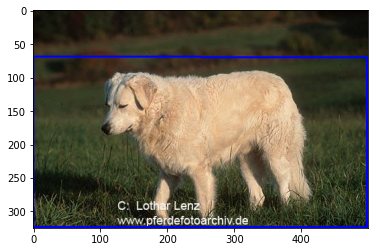

In [31]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [gradcam_rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

-> bbox도 엉망진창..(어느정도 해결!)

원인은 위와 마찬가지로 모델의 학습 문제였다.

## iou구하기

dataset에 이미 minmax bbox가 라벨링 되어있다.

In [49]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다.
# 즉, rect 좌표 (x,y) 형태를 받아 minmax 형태로 반환

def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [50]:
#예측 bbox prediction: CAM

cam_pred_bbox = rect_to_minmax(cam_rect, item['image'])
cam_pred_bbox

[0.2123076923076923, 0.068, 0.9107692307692308, 0.924]

In [51]:
#예측 bbox prediction: grad-CAM

gradcam_pred_bbox = rect_to_minmax(gradcam_rect, item['image'])
gradcam_pred_bbox

[0.2123076923076923, 0.0, 0.9938461538461538, 0.996]

In [52]:
#실제 bbox ground truth

item['objects']['bbox']

array([[0.27384615, 0.2       , 0.9969231 , 0.836     ]], dtype=float32)

In [53]:
#IoU 계산

def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [54]:
cam_IOU = get_iou(cam_pred_bbox, item['objects']['bbox'][0])
grad_IOU = get_iou(gradcam_pred_bbox, item['objects']['bbox'][0])

In [56]:
print('IoU for CAM: ', cam_IOU)
print('IoU for grad-CAM:', grad_IOU)

IoU for CAM:  0.6206487252606907
IoU for grad-CAM: 0.5867991848067436


## 회고하기

1. 모델의 분류기 부분이 제대로 학습이 되어야 CAM / grad-CAM이 feature map의 어떤 부분을 activation하는 것인지 파악할 수 있다는 것을  
   시각적으로 파악할 수 있었다.
 
2. cam / grad-cam의 분류기 성능을 높히는 것 이외에 bounding box외각선 그리는 함수의 thresh hold를 어떻게 바꿔야 더 효과적으로 바뀔지  
   파악하는 것이 필요하다. 이를 위해서는 각 output의 image histogram으로 시각화 해보는 게 필요할 것 같다.
